In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# define the four box model
# the box model should account for the main sources of sea level rise
# we have 4 contibuting boxes: Greenland, Antarctica, Glaciers, thermal expansion


# greenland
## source: snowfall -> dependent of air temperature and area
## sink: melt -> dependent of air temperature and area on the edge of the ice sheet
## sink: discharge -> dependent of the ice sheet contact area with ocean, and ocean temperature

### So our total parameters are T_air, T_ocean, A_snowfall, A_melt, A_discharge

def greenland(T_air, T_ocean, A_snowfall, A_melt, A_discharge, rain_constant, discharge_constant, melt_constant):
    """
    This function calculates the net mass balance of Greenland for a single time step.

    Args:
        T_air (float): Air temperature (Celsius)
        T_ocean (float): Ocean temperature (Celsius)
        A_snowfall (float): Snowfall area (km^2)
        A_melt (float): Melt area (km^2)
        A_discharge (float): Discharge area (km^2)

    Returns:
        float: Net mass balance of Greenland (mm/year)
    """
    # calculate the source of snowfall
    water_carrying_capacity = 6.6106 * np.exp(0.0499 * T_air)
    S_snowfall = A_snowfall * water_carrying_capacity * rain_constant

    # calculate the sink of melt
    S_melt = A_melt * T_ocean**melt_constant
    # calculate the sink of discharge
    S_discharge = A_discharge * T_ocean * discharge_constant
    return S_melt + S_discharge - S_snowfall


# Antarctica
## same as Greenland but with different parameters
antartica = greenland

# glaciers
## same as ice sheets, but without discharge

def glaciers(T_air, T_ocean, A_snowfall, A_melt, rain_constant):
    """
    This function calculates the net mass balance of glaciers for a single time step.
    """
    return greenland(T_air, T_ocean, A_snowfall, A_melt, 0, 0, 0, 0)

# thermal expansion
def thermal_expansion(V_0, T):
    """
    $$
        delta V = beta V_0 T
    $$

    we use beta = 2.23 times 10^{-4} / C^{circ}
    """
    beta = 2.23 * 10**(-4)
    return beta * V_0 * T

def four_box_model(T, A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant):
    """
    This function calculates the net mass balance of the four box model for a single time step.

    TODO: insert seperate terms for T_air, T_ocean

    """
    T_air, T_ocean = T, T
    green = greenland(T_air, T_ocean, A_snowfall, A_melt, A_discharge, rain_constant, discharge_constant, melt_constant)
    ant = antartica(T_air, T_ocean, A_snowfall, A_melt, A_discharge, rain_constant, discharge_constant, melt_constant)
    glaci = glaciers(T_air, T_ocean, A_snowfall, A_melt, rain_constant)
    therm = thermal_expansion(V_0, T_ocean)
    return green + ant + glaci + therm


T=20
A_snowfall = 10
A_melt = 10
A_discharge = 10
V_0 = 10
rain_constant = 1
discharge_constant = 1
melt_constant = 1
S_0 = 0

four_box_model(T, A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant)


451.3731835499735

len of df_T 175
len of df_T_forecast 100


Text(0, 0.5, 'Sea Level (mm)')

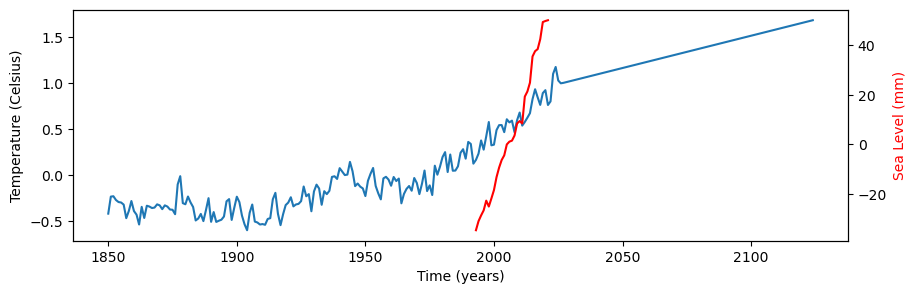

In [51]:
# we have data for T_air and T_ocean
# we fit against measure sea level rise
# use MCMC to find the best parameters


# load data
df_T_forecast = pd.read_csv('data/T_forecast_auto_arima.csv', index_col=0)
df_T = pd.read_csv('data/processed_temperature_data.csv', index_col=0)
df_S = pd.read_csv('data/processed_sea_level_data.csv', index_col=0)

# stack df_T with forecast
print('len of df_T', len(df_T))
print('len of df_T_forecast', len(df_T_forecast))
df_T = pd.concat([df_T, df_T_forecast])
df_T_annual = df_T.Annual
df_T_uncertainty = df_T.Annual_uncertainty
df_T_annual, df_T_uncertainty

df_S_annual = df_S.GMSL_noGIA
df_S_uncertainty = df_S.uncertainty


# now the data is ready, we will plot

fig, ax = plt.subplots(figsize=(10, 3))
ax2 = ax.twinx()

ax.plot(df_T_annual, label='Temperature')
ax2.plot(df_S_annual, label='Sea Level', color='red')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Temperature (Celsius)')
ax2.set_ylabel('Sea Level (mm)', color='red')


Running burn-in...


  0%|          | 0/30000 [00:00<?, ?it/s]/Users/tonton/anaconda3/envs/pymc_env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 30000/30000 [00:09<00:00, 3125.45it/s]


Running production...


100%|██████████| 200000/200000 [01:05<00:00, 3055.28it/s]


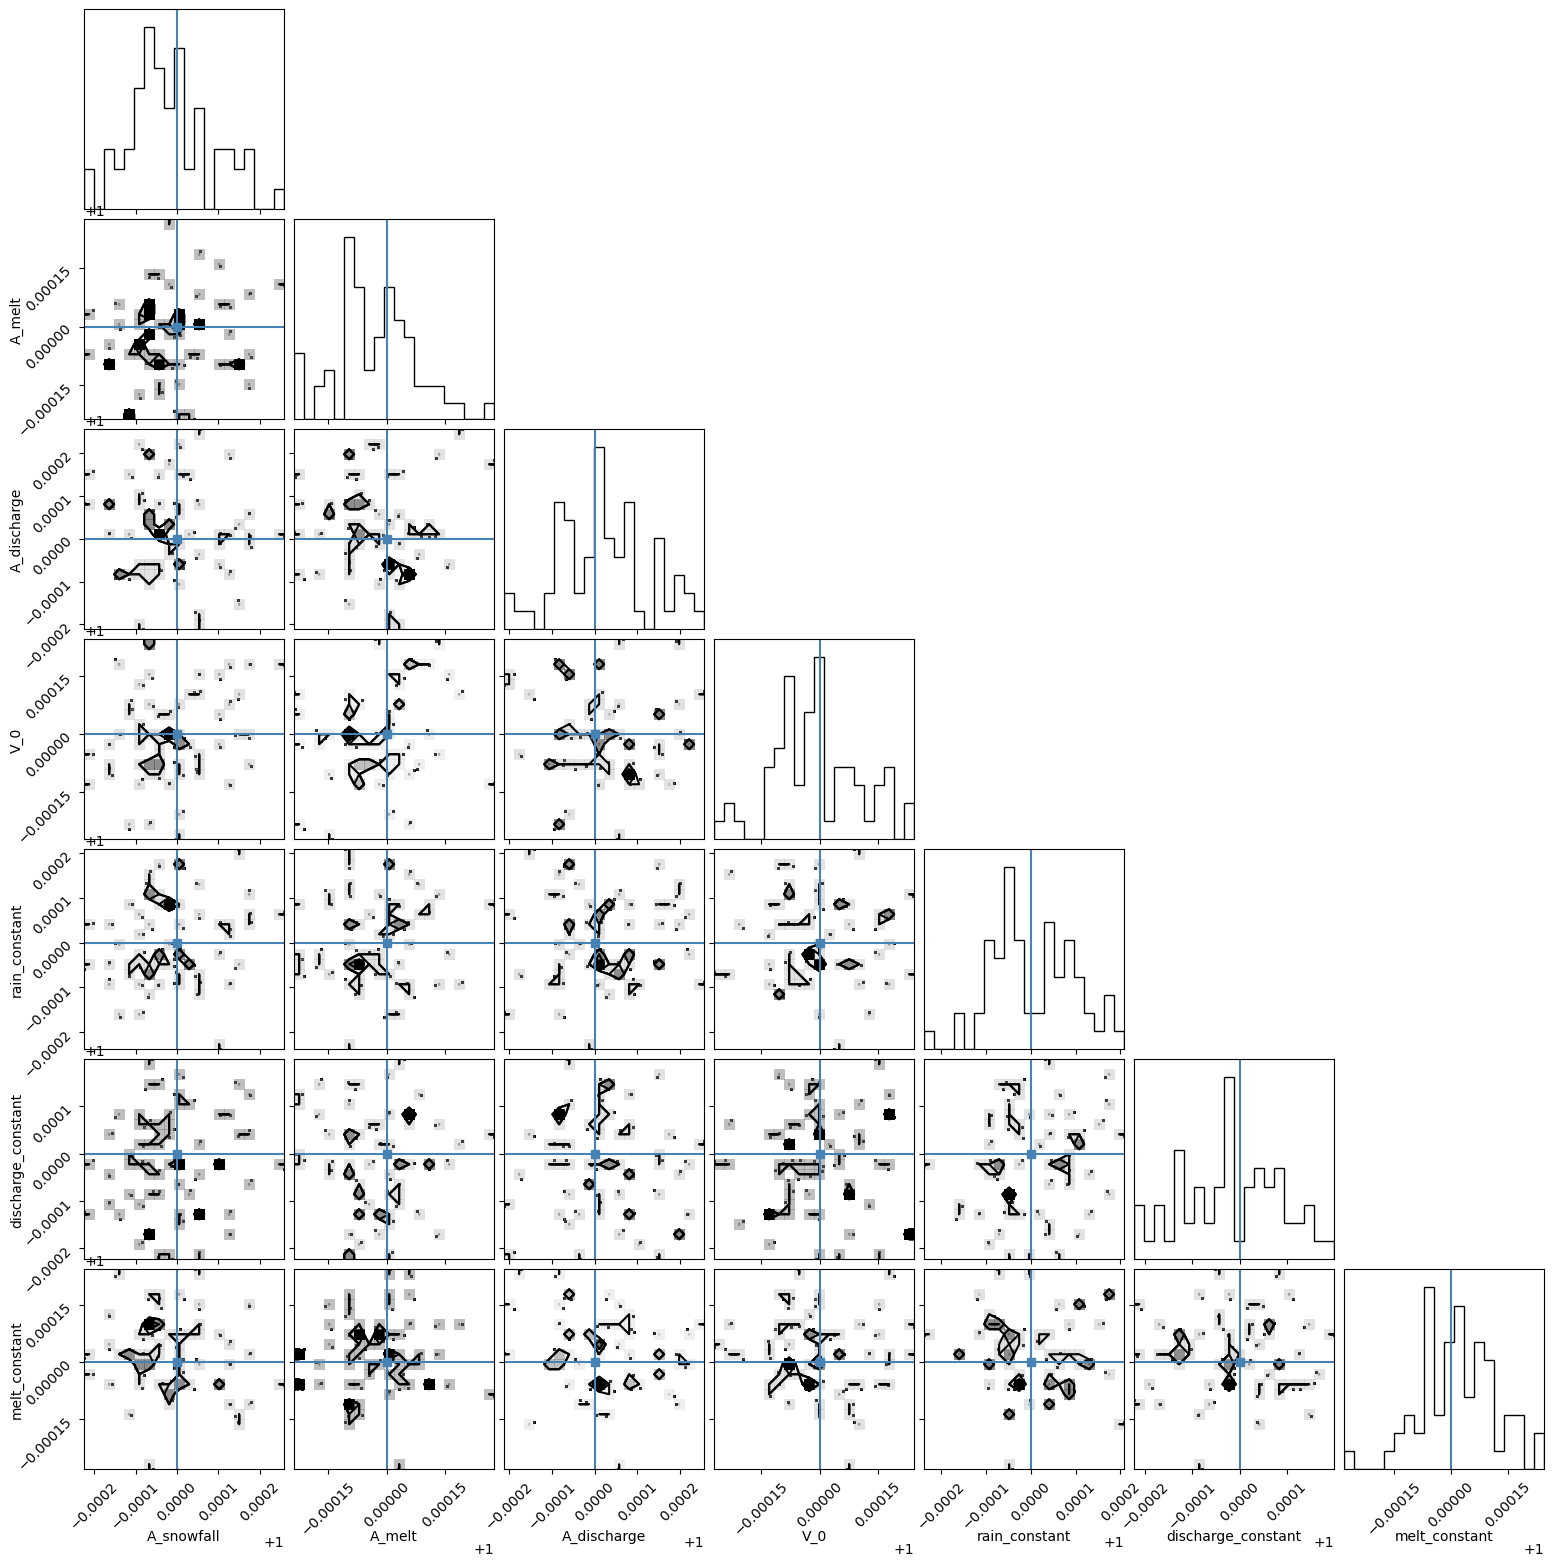

a = 1.000 (+0.000, -0.000)
b = 1.000 (+0.000, -0.000)
S_0 = 1.000 (+0.000, -0.000)
tau = 1.000 (+0.000, -0.000)
Parameter 4 = 1.000 (+0.000, -0.000)
Parameter 5 = 1.000 (+0.000, -0.000)
Parameter 6 = 1.000 (+0.000, -0.000)


/var/folders/s5/y8d9ljs52g7bqbgnrq59ltv40000gn/T/ipykernel_3704/2562875667.py:35: RuntimeWarning: invalid value encountered in power
  S_melt = A_melt * T_ocean**melt_constant


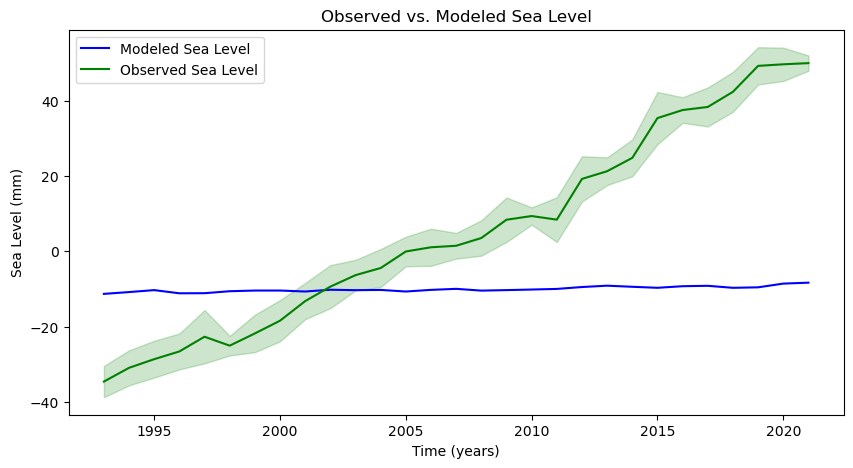

In [67]:
# we need to find the best parameters for the four box model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

# Assume df_T and df_S are your dataframes with temperature and sea level data
# df_T should have an index of time and a column 'Annual' for temperature anomalies
# df_S should have an index of time and columns 'GMSL_noGIA' for sea level and 'uncertainty' for measurement errors

# Extract time and temperature data
time = df_T.index.values
T = df_T['Annual'].values


# Observed sea level data and uncertainties
S_obs = df_S['GMSL_noGIA'].values #* 1e-3
sigma = df_S['uncertainty'].values #* 1e-3
offset = 100

# Define the model function
def get_dS(T, A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant):
    dS = four_box_model(T, A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant)
    return dS

# Define the log prior function
def log_prior(theta):
    # print('theta', theta, len(theta))   
    A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant = theta
    cond3 = -5200 < A_snowfall < 220
    cond4 = 20 < A_melt < 60
    cond5 = 20 < A_discharge < 60
    cond6 = 20 < V_0 < 60
    cond7 = 20 < rain_constant < 60
    cond8 = 20 < discharge_constant < 60
    cond9 = 20 < melt_constant < 60
    if cond3 and cond4 and cond5 and cond6 and cond7 and cond8 and cond9:
        return 0.0  # Uniform prior (log probability is zero within bounds)
    return -np.inf  # Log probability is -infinity outside bounds

# Define the log likelihood function
def log_likelihood(theta, T, S_obs, sigma):
    # print('theta', theta    )
    A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant = theta
    dS = get_dS(T,A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant)
    S_model = np.cumsum(dS)
    # Align S_model and S_obs based on your original offset
      # Adjust this value if necessary
    S_model_aligned = S_model[-len(S_obs)-offset:-offset]
    # Compute the log likelihood assuming Gaussian errors
    return -0.5 * np.sum(((S_obs - S_model_aligned) / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the full log probability function
def log_probability(theta, T, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T, S_obs, sigma)

# Initial guess for the parameters
initial = [1, 1, 1, 1, 1, 1, 1,]

# Set up the MCMC sampler
ndim = len(initial)  # Number of parameters
nwalkers = 64  # Number of MCMC walkers
# Initialize the walkers in a small Gaussian ball around the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Run MCMC using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(T, S_obs, sigma))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 30000, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 200000, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions
fig = corner.corner(samples, labels=["A_snowfall", "A_melt", "A_discharge", "V_0", "rain_constant", "discharge_constant", "melt_constant"], truths=initial)
plt.show()

# Compute the mean and uncertainties of the parameters
from IPython.display import display, Math
import scipy.stats as stats

param_names = ["a", "b", "S_0", "tau"]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    if i < len(param_names):
        txt = "{0} = {1:.3f} (+{2:.3f}, -{3:.3f})".format(param_names[i], mcmc[1], q[1], q[0])
    else:
        txt = "Parameter {0} = {1:.3f} (+{2:.3f}, -{3:.3f})".format(i, mcmc[1], q[1], q[0])
    print(txt)

# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)
a_best, b_best, S_0_best, tau_best, rain_constant_best, discharge_constant_best, melt_constant_best = best_params
S_model_full = get_dS(T, a_best, b_best, S_0_best, tau_best, rain_constant_best, discharge_constant_best, melt_constant_best)
S_model_aligned = S_model_full[-len(S_obs)-offset:-offset]

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(df_S.index, S_model_aligned, label='Modeled Sea Level', color='blue')
plt.plot(df_S.index, S_obs, label='Observed Sea Level', color='green')

plt.fill_between(df_S.index, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)
plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()






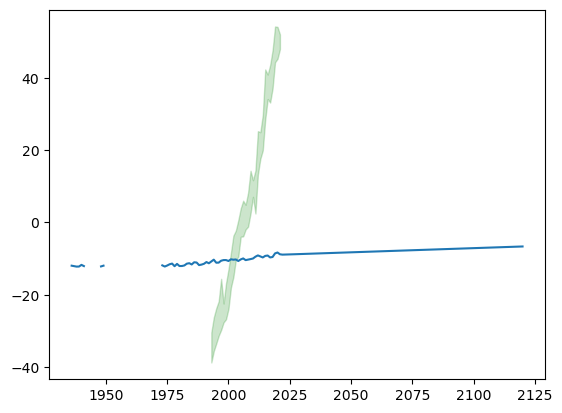

In [66]:
index_full = np.arange(2121-275, 2121)

plt.plot(index_full, S_model_full)
plt.fill_between(df_S.index, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)

Running burn-in...


  0%|          | 0/3000 [00:00<?, ?it/s]/Users/tonton/anaconda3/envs/pymc_env/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:00<00:00, 3231.46it/s]


Running production...


100%|██████████| 20000/20000 [00:06<00:00, 3247.86it/s]


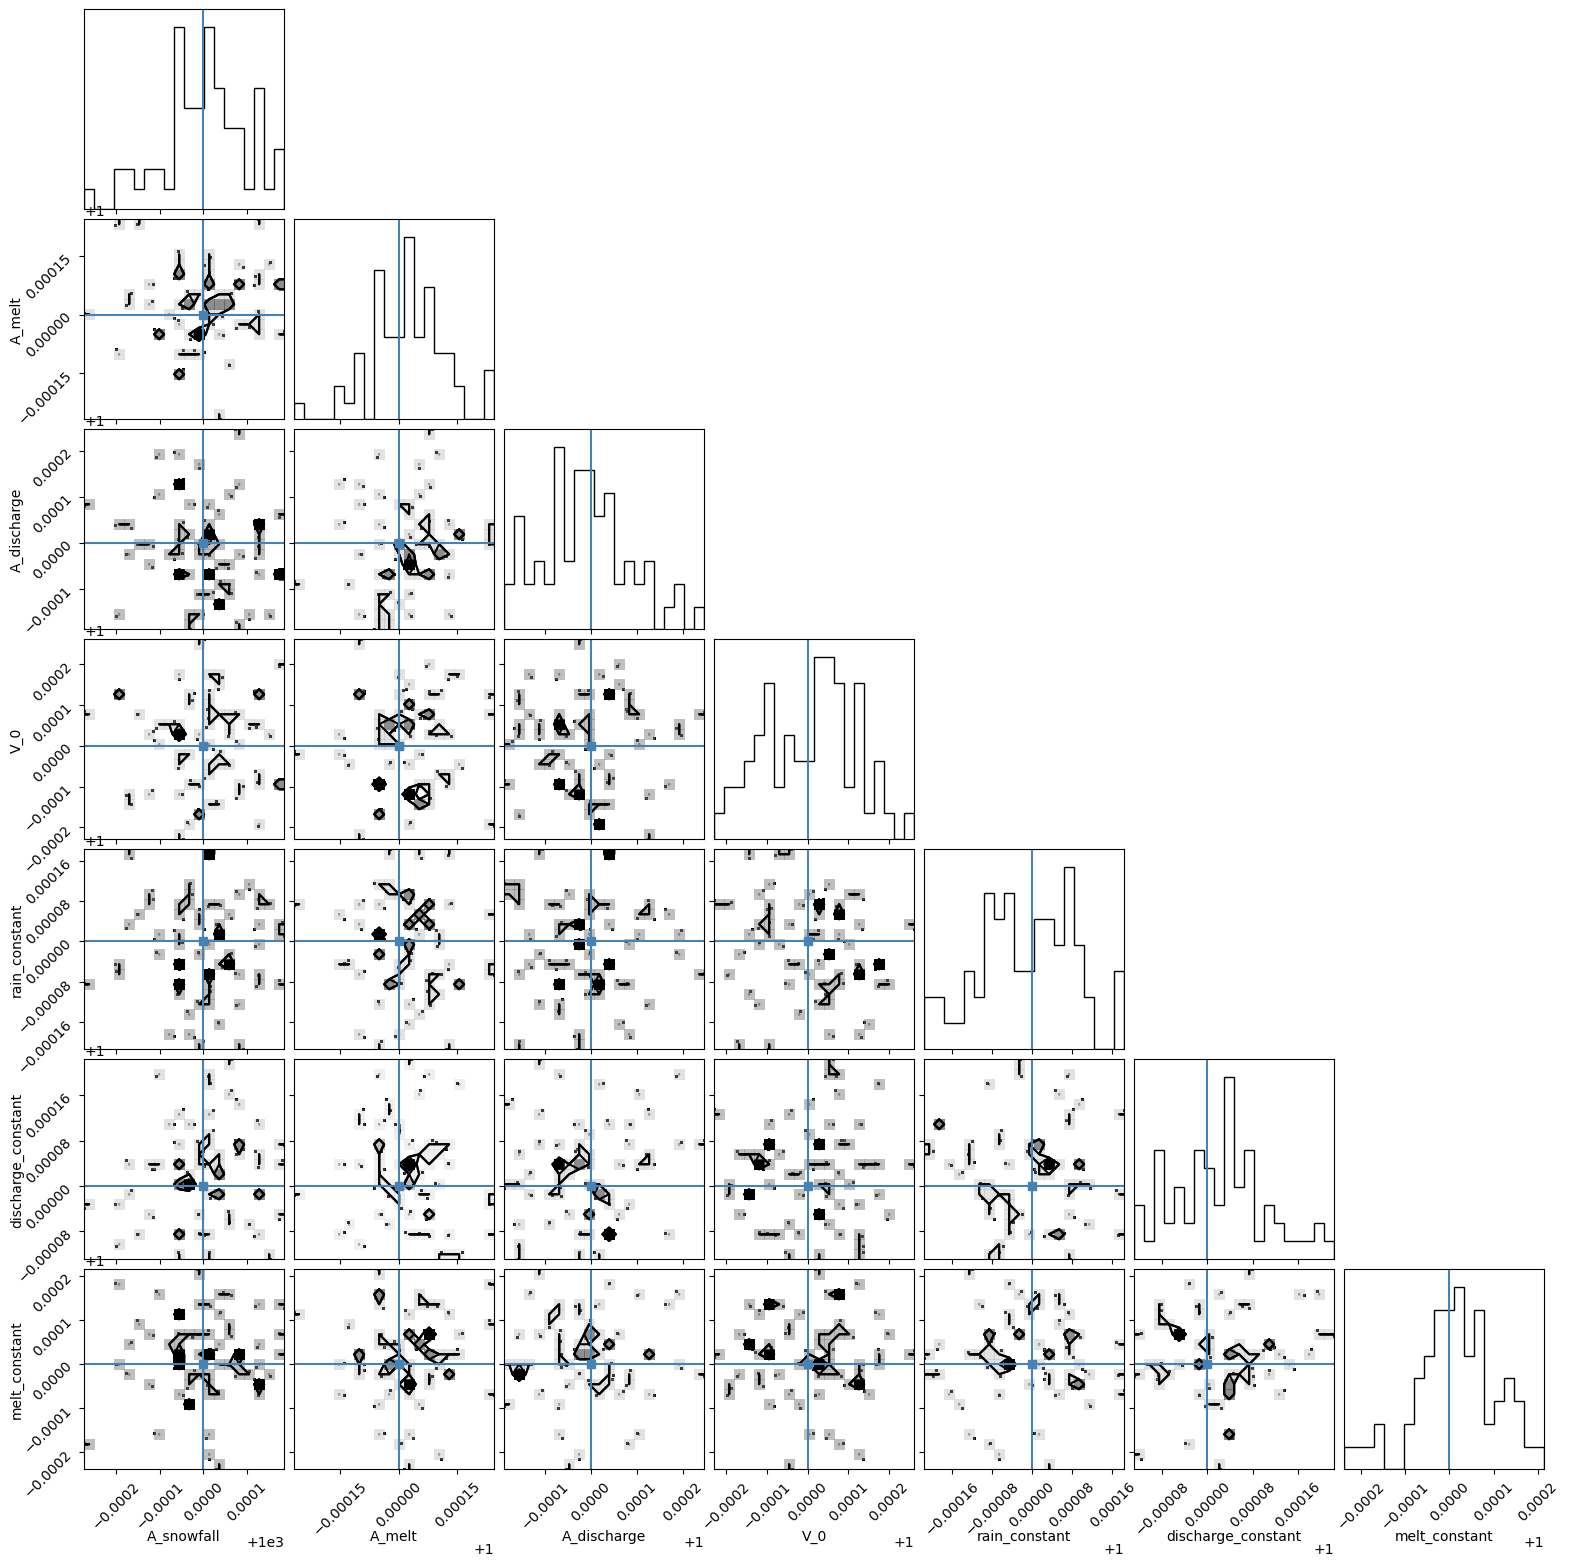

A_snowfall = 1000.000 (+0.000, -0.000)
A_melt = 1.000 (+0.000, -0.000)
A_discharge = 1.000 (+0.000, -0.000)
V_0 = 1.000 (+0.000, -0.000)
rain_constant = 1.000 (+0.000, -0.000)
discharge_constant = 1.000 (+0.000, -0.000)
melt_constant = 1.000 (+0.000, -0.000)


/var/folders/s5/y8d9ljs52g7bqbgnrq59ltv40000gn/T/ipykernel_3704/2562875667.py:35: RuntimeWarning: invalid value encountered in power
  S_melt = A_melt * T_ocean**melt_constant


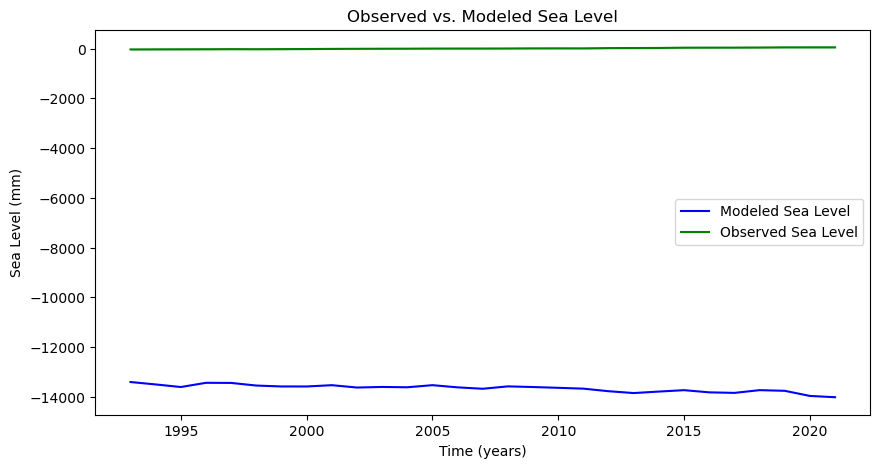

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

# Assuming df_T and df_S are already provided as dataframes with relevant temperature and sea level data.

# Extract time and temperature data
time = df_T.index.values
T = df_T['Annual'].values

# Observed sea level data and uncertainties
S_obs = df_S['GMSL_noGIA'].values
sigma = df_S['uncertainty'].values
offset = 100  # Adjust this value as needed

# Define the four-box model (assumed to be provided elsewhere)
def get_dS(T, A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant):
    return four_box_model(T, A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant)

# Define the log prior function
def log_prior(theta):
    A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant = theta
    if -5200 < A_snowfall and A_snowfall < 220 and \
       20 < A_melt and A_melt < 60 and \
       20 < A_discharge and A_discharge < 60 and \
       20 < V_0 and V_0 < 60 and \
       20 < rain_constant and rain_constant < 60 and \
       20 < discharge_constant and discharge_constant < 60 and \
       20 < melt_constant and melt_constant < 60:
        return 0.0  # Uniform prior within bounds
    return -np.inf  # Outside the bounds, log probability is negative infinity

# Define the log likelihood function
def log_likelihood(theta, T, S_obs, sigma):
    A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant = theta
    dS = get_dS(T, A_snowfall, A_melt, A_discharge, V_0, rain_constant, discharge_constant, melt_constant)
    
    if np.any(np.isnan(dS)) or np.any(np.isinf(dS)):
        return -np.inf
    
    S_model = np.cumsum(dS)
    S_model_aligned = S_model[-len(S_obs)-offset:-offset]
    
    residuals = (S_obs - S_model_aligned) / sigma
    log_likelihood_val = -0.5 * np.sum(residuals**2 + np.log(2 * np.pi * sigma**2))
    
    if np.isnan(log_likelihood_val) or np.isinf(log_likelihood_val):
        return -np.inf
    
    return log_likelihood_val

# Define the full log probability function
def log_probability(theta, T, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T, S_obs, sigma)

# Initial guess for the parameters
initial_params = [1000, 1, 1, 1, 1, 1, 1]
ndim = len(initial_params)  # Number of parameters
nwalkers = 64  # Number of walkers for MCMC

# Initialize walkers in a Gaussian ball around the initial guess
pos = initial_params + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(T, S_obs, sigma))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 3000, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 20000, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions using the corner library
fig = corner.corner(samples, labels=["A_snowfall", "A_melt", "A_discharge", "V_0", "rain_constant", "discharge_constant", "melt_constant"], truths=initial_params)
plt.show()

# Compute the mean and uncertainties of the parameters
param_names = ["A_snowfall", "A_melt", "A_discharge", "V_0", "rain_constant", "discharge_constant", "melt_constant"]
for i, name in enumerate(param_names):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")

# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)
S_model_full = get_dS(T, *best_params)
S_model_aligned = S_model_full[-len(S_obs)-offset:-offset]

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(df_S.index, S_model_aligned, label='Modeled Sea Level', color='blue')
plt.plot(df_S.index, S_obs, label='Observed Sea Level', color='green')

# Add uncertainty bounds
plt.fill_between(df_S.index, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)

plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()